In [1]:
# try:
#     import google.colab

#     COLAB = True
# except ModuleNotFoundError:
#     COLAB = False
#     pass

# if COLAB:
#     !apt -qq update -y
#     !apt -qq install swig -y
#     !pip -q install box2d-py
#     !pip -q install "gymnasium[classic-control, box2d, atari, accept-rom-license, mujoco]"
#     !pip -q install piglet
#     !pip -q install imageio_ffmpeg
#     !pip -q install moviepy==1.0.3
#     !pip -q install gymnasium[mujoco]t

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import numpy as np
from tqdm import tqdm
from collections import deque

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
lr_actor = 0.0003
lr_critic = 0.0003
Iter = 15000
MAX_STEP = 10000
gamma = 0.98
lambd = 0.98
batch_size = 64
epsilon = 0.2
l2_rate = 0.001
beta = 3


class Actor(nn.Module):
    def __init__(self, N_S, N_A):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(N_S, 64)
        self.fc2 = nn.Linear(64, 64)
        self.sigma = nn.Linear(64, N_A)
        self.mu = nn.Linear(64, N_A)
        self.mu.weight.data.mul_(0.1)
        self.mu.bias.data.mul_(0.0)
        # self.set_init([self.fc1,self.fc2, self.mu, self.sigma])
        self.distribution = torch.distributions.Normal

    def set_init(self, layers):
        for layer in layers:
            nn.init.normal_(layer.weight, mean=0.0, std=0.1)
            nn.init.constant_(layer.bias, 0.0)

    def forward(self, s):
        x = torch.tanh(self.fc1(s))
        x = torch.tanh(self.fc2(x))

        mu = self.mu(x)
        log_sigma = self.sigma(x)
        # log_sigma = torch.zeros_like(mu)
        sigma = torch.exp(log_sigma)
        return mu, sigma

    def choose_action(self, s):
        mu, sigma = self.forward(s)
        Pi = self.distribution(mu, sigma)
        return Pi.sample().cpu().numpy()


class Critic(nn.Module):
    def __init__(self, N_S):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(N_S, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.fc3.weight.data.mul_(0.1)
        self.fc3.bias.data.mul_(0.0)
        # self.set_init([self.fc1, self.fc2, self.fc2])

    def set_init(self, layers):
        for layer in layers:
            nn.init.normal_(layer.weight, mean=0.0, std=0.1)
            nn.init.constant_(layer.bias, 0.0)

    def forward(self, s):
        x = torch.tanh(self.fc1(s))
        x = torch.tanh(self.fc2(x))
        values = self.fc3(x)
        return values


class Ppo:
    def __init__(self, N_S, N_A):
        self.actor_net = Actor(N_S, N_A).to(device)
        self.critic_net = Critic(N_S).to(device)
        self.actor_optim = optim.Adam(self.actor_net.parameters(), lr=lr_actor)
        self.critic_optim = optim.Adam(
            self.critic_net.parameters(), lr=lr_critic, weight_decay=l2_rate
        )
        self.critic_loss_func = torch.nn.MSELoss()

    def train(self, memory):
        # memory = np.array(memory)
        states = torch.tensor(
            np.vstack(np.array([val[0] for val in memory])), dtype=torch.float32
        ).to(device)

        actions = torch.tensor(
            np.array([val[1] for val in memory]), dtype=torch.float32
        ).to(device)
        rewards = torch.tensor(
            np.array([val[2] for val in memory]), dtype=torch.float32
        ).to(device)
        masks = torch.tensor(
            np.array([val[3] for val in memory]), dtype=torch.float32
        ).to(device)

        values = self.critic_net(states)

        returns, advants = self.get_gae(rewards, masks, values)
        old_mu, old_std = self.actor_net(states)
        pi = self.actor_net.distribution(old_mu, old_std)

        old_log_prob = pi.log_prob(actions).sum(1, keepdim=True)

        n = len(states)
        arr = np.arange(n)
        for epoch in range(1):
            np.random.shuffle(arr)
            for i in range(n // batch_size):
                b_index = arr[batch_size * i : batch_size * (i + 1)]
                b_states = states[b_index]
                b_advants = advants[b_index].unsqueeze(1)
                b_actions = actions[b_index]
                b_returns = returns[b_index].unsqueeze(1)

                mu, std = self.actor_net(b_states)
                pi = self.actor_net.distribution(mu, std)
                new_prob = pi.log_prob(b_actions).sum(1, keepdim=True)
                old_prob = old_log_prob[b_index].detach()
                # KL_penalty = self.kl_divergence(old_mu[b_index],old_std[b_index],mu,std)
                ratio = torch.exp(new_prob - old_prob)

                surrogate_loss = ratio * b_advants
                values = self.critic_net(b_states)

                critic_loss = self.critic_loss_func(values, b_returns)

                self.critic_optim.zero_grad()
                critic_loss.backward()
                self.critic_optim.step()

                ratio = torch.clamp(ratio, 1.0 - epsilon, 1.0 + epsilon)

                clipped_loss = ratio * b_advants

                actor_loss = -torch.min(surrogate_loss, clipped_loss).mean()
                # actor_loss = -(surrogate_loss-beta*KL_penalty).mean()

                self.actor_optim.zero_grad()
                actor_loss.backward()

                self.actor_optim.step()

    def kl_divergence(self, old_mu, old_sigma, mu, sigma):
        old_mu = old_mu.detach()
        old_sigma = old_sigma.detach()

        kl = (
            torch.log(old_sigma)
            - torch.log(sigma)
            + (old_sigma.pow(2) + (old_mu - mu).pow(2)) / (2.0 * sigma.pow(2))
            - 0.5
        )
        return kl.sum(1, keepdim=True)

    def get_gae(self, rewards, masks, values):
        rewards = torch.Tensor(rewards)
        masks = torch.Tensor(masks)
        returns = torch.zeros_like(rewards)
        advants = torch.zeros_like(rewards)
        running_returns = 0
        previous_value = 0
        running_advants = 0

        for t in reversed(range(0, len(rewards))):
            running_returns = rewards[t] + gamma * running_returns * masks[t]
            running_tderror = (
                rewards[t] + gamma * previous_value * masks[t] - values.data[t]
            )
            running_advants = (
                running_tderror + gamma * lambd * running_advants * masks[t]
            )

            returns[t] = running_returns
            previous_value = values.data[t]
            advants[t] = running_advants
        advants = (advants - advants.mean()) / advants.std()
        return returns, advants


class Nomalize:
    def __init__(self, N_S):
        self.mean = np.zeros((N_S,))
        self.std = np.zeros((N_S,))
        self.stdd = np.zeros((N_S,))
        self.n = 0

    def __call__(self, x):
        x = np.asarray(x)
        self.n += 1
        if self.n == 1:
            self.mean = x
        else:
            old_mean = self.mean.copy()
            self.mean = old_mean + (x - old_mean) / self.n
            self.stdd = self.stdd + (x - old_mean) * (x - self.mean)
        if self.n > 1:
            self.std = np.sqrt(self.stdd / (self.n - 1))
        else:
            self.std = self.mean

        x = x - self.mean
        x = x / (self.std + 1e-8)
        x = np.clip(x, -5, +5)

        return x

In [4]:
env = gym.make("Humanoid-v4")
N_S = env.observation_space.shape[0]
N_A = env.action_space.shape[0]
# env.seed(500)
torch.manual_seed(500)
np.random.seed(500)

ppo = Ppo(N_S, N_A)
nomalize = Nomalize(N_S)
episodes = 0
eva_episodes = 0
scores_total = list()
for iter in tqdm(range(Iter)):
    memory = deque()
    scores = []
    steps = 0
    while steps < 2048:
        episodes += 1
        s = nomalize(env.reset()[0])
        score = 0
        for _ in range(MAX_STEP):
            steps += 1
            a = ppo.actor_net.choose_action(
                torch.from_numpy(np.array(s).astype(np.float32)).unsqueeze(0).to(device)
            )[0]
            s_, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated
            s_ = nomalize(s_)

            mask = (1 - done) * 1
            memory.append([s, a, r, mask])

            score += r
            s = s_
            if done:
                break
        scores.append(score)
    score_avg = np.mean(scores)
    scores_total.append(score_avg)
    print("{} episode score is {:.2f}".format(episodes, score_avg))
    ppo.train(memory)

  0%|          | 0/15000 [00:00<?, ?it/s]

94 episode score is 71.32


  0%|          | 1/15000 [00:03<15:39:17,  3.76s/it]

187 episode score is 72.08


  0%|          | 2/15000 [00:06<13:14:30,  3.18s/it]

281 episode score is 71.93


  0%|          | 3/15000 [00:09<12:14:22,  2.94s/it]

373 episode score is 73.97


  0%|          | 4/15000 [00:11<11:57:04,  2.87s/it]

464 episode score is 75.56


  0%|          | 5/15000 [00:14<11:37:09,  2.79s/it]

551 episode score is 79.39


  0%|          | 6/15000 [00:17<11:29:14,  2.76s/it]

638 episode score is 79.94


  0%|          | 7/15000 [00:19<11:18:46,  2.72s/it]

721 episode score is 84.10


  0%|          | 8/15000 [00:22<11:11:20,  2.69s/it]

801 episode score is 88.49


  0%|          | 9/15000 [00:25<11:00:33,  2.64s/it]

875 episode score is 95.38


  0%|          | 10/15000 [00:27<11:11:22,  2.69s/it]

953 episode score is 91.22


  0%|          | 10/15000 [00:30<12:43:45,  3.06s/it]


KeyboardInterrupt: 

Text(0.5, 1.0, 'scores_total')

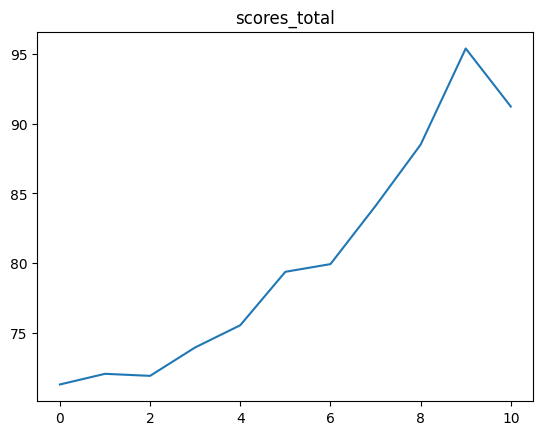

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(scores_total)
plt.title("scores_total")

In [14]:
torch.save(ppo.actor_net.state_dict(), "actor_net.pth")
torch.save(ppo.critic_net.state_dict(), "critic_net.pth")